# ML Lab

This notebook is developed for the "Optimisation & Machine Learning" workshop, organised by UK Metamaterials Network (UKMMN); for educational purposes only.
- Authors: Amber Wang, Erin Yu & Ajit Panesar (IDEA Lab, Imperial College London)
- Version: v1 (20/01/2026)
- Comments and corrections to a.panesar@imperial.ac.uk, a.wang20@imperial.ac.uk

--------------

# (a). ML introduction

### Content of ML Lab (a) tutorial

In this lab, you will learn ML capability on three tasks:
1) **Regression**  
   Predict a continuous property from tabular features  
   (linear model and nonlinear MLP)

2) **Classification**  
   Identify types from images  
   (logistic regression and CNN)

3) **Unsupervised learning**  
   Discover structure in data without labels  
   ( KMeans clustering)

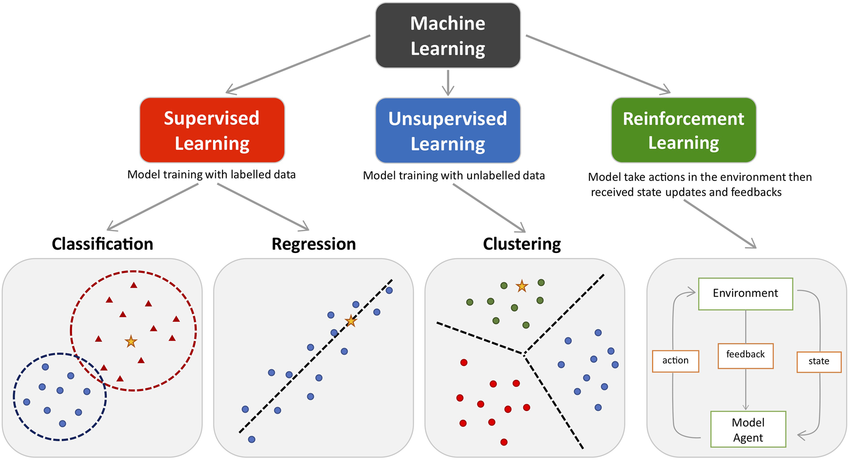

<span style="color: gray;">Figure from Junjie Peng et al. "Machine Learning Techniques for Personalised Medicine Approaches in Immune-Mediated Chronic Inflammatory Diseases: Applications and Challenges". https://doi.org/10.3389/fphar.2021.720694.</span>

--------------

### Before you get started - Import library

Run the cell below to import necessarry python libraries for this tutorial.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import MNIST

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.datasets import fetch_openml

--------------

### 1. Regression with tabular data

In a regression task, the goal is to learn a function that maps a set of input features to a continuous numerical output.

#### Dataset

We use the **Concrete Compressive Strength dataset**, a widely used benchmark in machine learning and materials science.

- **Inputs (features)**  
  Each data point represents the composition and age of a concrete sample.  
  The input features include:
  - cement content
  - blast furnace slag
  - fly ash
  - water
  - superplasticizer
  - coarse aggregate
  - fine aggregate
  - age (in days)

  All inputs are continuous physical quantities related to material composition and curing conditions.

- **Output (target)**  
  The target is a **continuous value** representing the compressive strength of the concrete, typically measured in MPa.

This dataset is well suited for regression because:
- the underlying physical process is real and well understood
- relationships between inputs and strength are highly nonlinear
- interactions between components are important

#### Models compared

We compare two models with different expressive power:

- **Linear Regression**  
  A simple baseline that assumes a linear relationship between material composition and strength.

- **Multilayer Perceptron (MLP)**  
  A neural network with hidden layers capable of learning nonlinear relationships and feature interactions.

By comparing their predictions and errors, we can see how nonlinear models better capture complex physical dependencies.

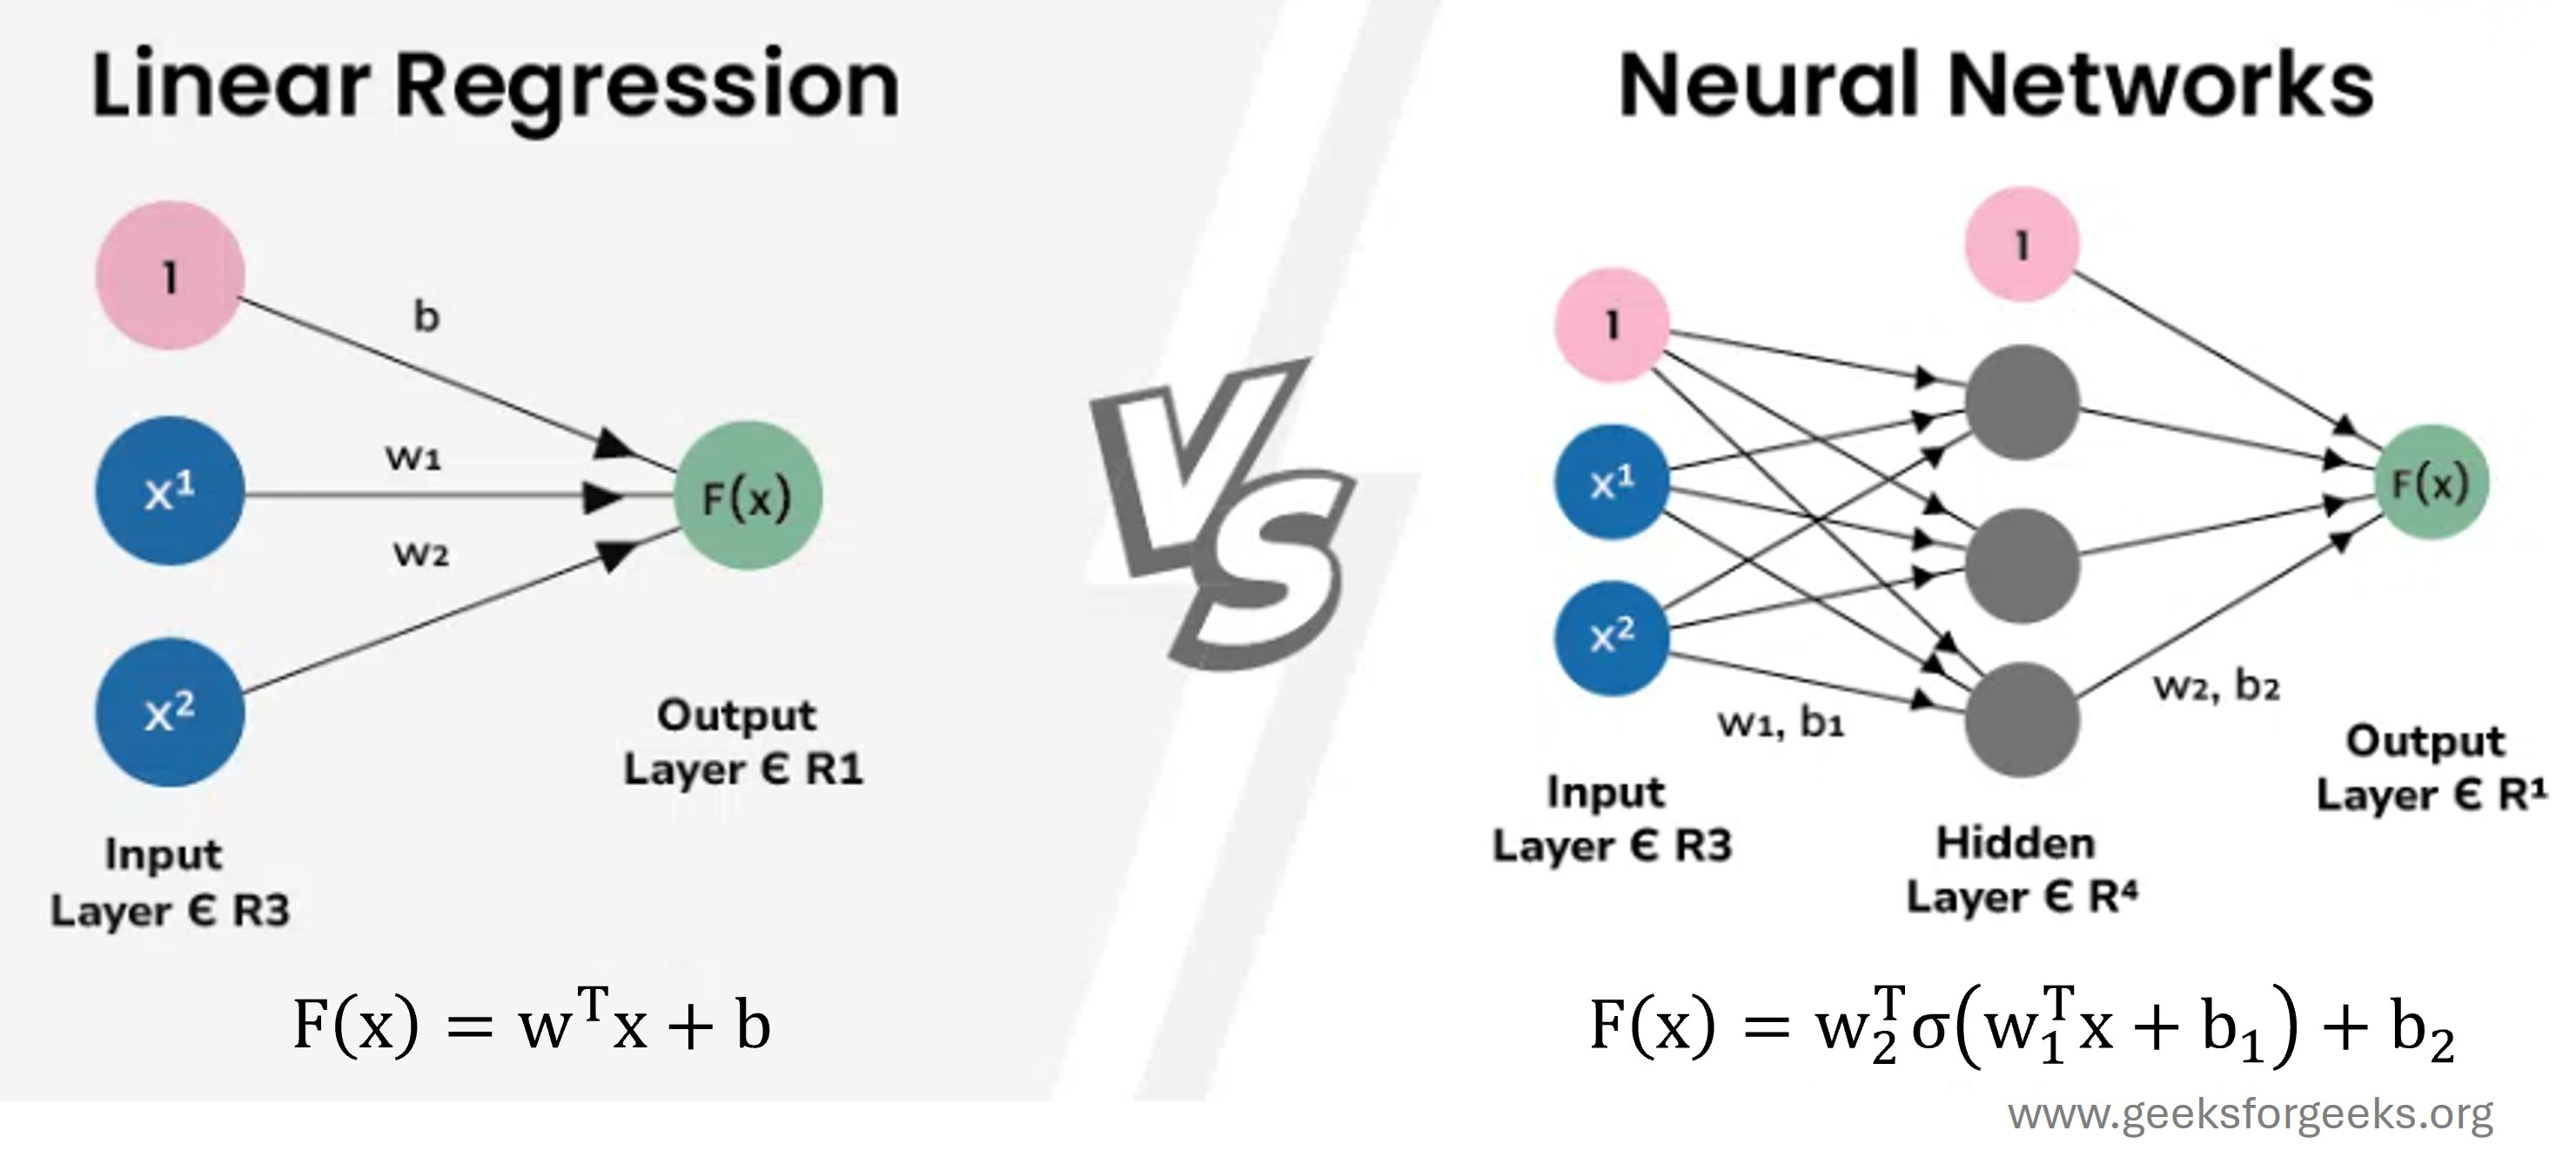

#### 1.1 View the dataset

Dataset: Concrete Compressive Strength | Samples: 1030 | Features: 8
Features: ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer', 'coarse_aggregate', 'fine_aggregate', 'age']
Target: strength (MPa, continuous)


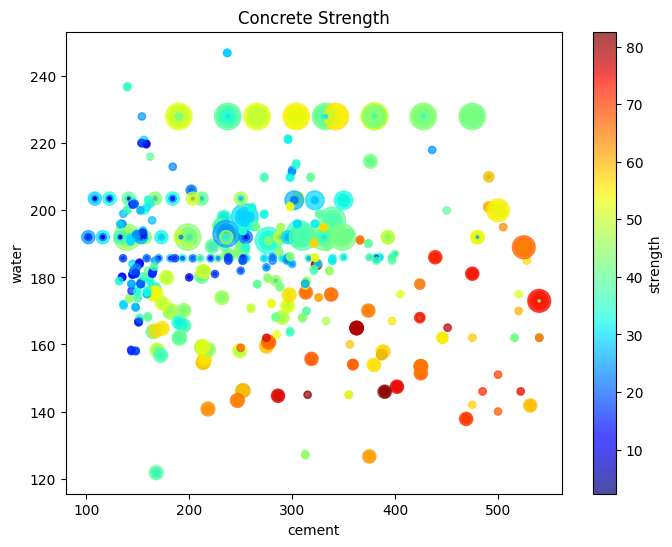

In [3]:
# Load dataset
data = fetch_openml(data_id=44959, as_frame=True)
concrete = data.frame
X, y = concrete.drop(columns=["strength"]).to_numpy(), concrete["strength"].to_numpy()
# Print dataset information
print(f"Dataset: Concrete Compressive Strength | Samples: {X.shape[0]} | Features: {X.shape[1]}")
print("Features:", list(concrete.columns.drop("strength")))
print("Target:", "strength", "(MPa, continuous)")
# Visualise dataset 
concrete.head()
concrete.plot(kind="scatter", x="cement", y="water", c="strength", cmap="jet", colorbar=True, figsize=(8,6), s=concrete["age"]/1, alpha=0.7)
plt.title("Concrete Strength")
plt.show()

#### 1.2 Train the Linear Regression model and MLP model


Regression results (test set)
Linear Regression: MAE=7.865, R2=0.637
MLP             : MAE=3.728, R2=0.891


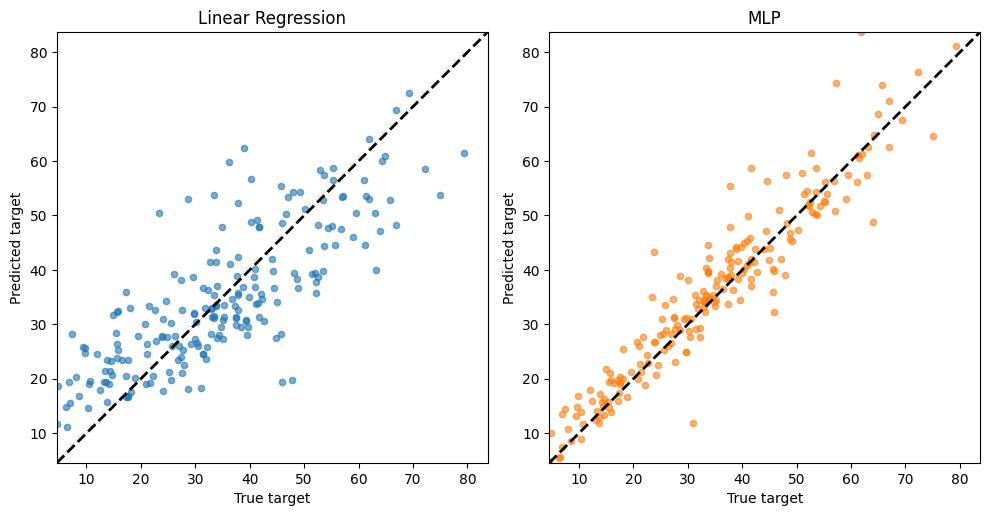

In [3]:
# 1) Prepare dataset
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=0)

# 3) Scale inputs
scaler = StandardScaler()
Xtr_s, Xte_s = scaler.fit_transform(Xtr), scaler.transform(Xte)

# 4) Linear regression
lin = LinearRegression().fit(Xtr_s, ytr)
y_lin = lin.predict(Xte_s)

# 5) MLP (PyTorch) — standardise target
y_mean, y_std = ytr.mean(), ytr.std() + 1e-8
ytr_s = (ytr - y_mean) / y_std

Xtr_t = torch.tensor(Xtr_s, dtype=torch.float32)
ytr_t = torch.tensor(ytr_s, dtype=torch.float32).unsqueeze(1)
Xte_t = torch.tensor(Xte_s, dtype=torch.float32)

loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=256, shuffle=True)

mlp = nn.Sequential(
    nn.Linear(Xtr_t.shape[1], 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),

    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),

    nn.Linear(128, 1)
)

opt = optim.AdamW(mlp.parameters(), lr=5e-4, weight_decay=1e-4)
loss_fn = nn.SmoothL1Loss()

for _ in range(400):
    for xb, yb in loader:
        opt.zero_grad()
        loss_fn(mlp(xb), yb).backward()
        opt.step()

with torch.no_grad():
    y_mlp = mlp(Xte_t).numpy().ravel() * y_std + y_mean

# 6) Metrics
print("\nRegression results (test set)")
print(f"Linear Regression: MAE={mean_absolute_error(yte, y_lin):.3f}, R2={r2_score(yte, y_lin):.3f}")
print(f"MLP             : MAE={mean_absolute_error(yte, y_mlp):.3f}, R2={r2_score(yte, y_mlp):.3f}")

# 7) Plot
color_linear, color_mlp = "tab:blue", "tab:orange"
ymin, ymax = min(yte.min(), y_lin.min(), y_mlp.min()), max(yte.max(), y_lin.max(), y_mlp.max())

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(yte, y_lin, s=20, alpha=0.6, color=color_linear)
plt.plot([ymin, ymax], [ymin, ymax], "--k", linewidth=2)
plt.gca().set(aspect="equal", xlim=(ymin, ymax), ylim=(ymin, ymax))
plt.xlabel("True target"); plt.ylabel("Predicted target"); plt.title("Linear Regression")

plt.subplot(1, 2, 2)
plt.scatter(yte, y_mlp, s=20, alpha=0.6, color=color_mlp)
plt.plot([ymin, ymax], [ymin, ymax], "--k", linewidth=2)
plt.gca().set(aspect="equal", xlim=(ymin, ymax), ylim=(ymin, ymax))
plt.xlabel("True target"); plt.ylabel("Predicted target"); plt.title("MLP")

plt.tight_layout()
plt.show()

**Interpreting the regression results**

The regression output reports two standard performance metrics: **mean absolute error (MAE)** and **coefficient of determination (R²)**.

**MAE** measures the average magnitude of prediction errors and is expressed in the same units as the target variable. Lower MAE indicates that predictions are, on average, closer to the true values.

**R²** measures how well the model explains the variability of the target. Values closer to 1 indicate that the model captures most of the structure in the data, while values closer to 0 indicate limited predictive power beyond a simple baseline.

Comparing the two models highlights the impact of model assumptions. A linear model can only represent linear relationships between inputs and output, which may be insufficient when the underlying process is nonlinear. A MLP, by contrast, can learn nonlinear relationships and interactions between features, often resulting in lower prediction error and higher explanatory power.

This comparison illustrates a general principle in regression: **model complexity should be matched to the structure of the data**.

### 2. Classification with images

In a classification task, the goal is to assign each input to one of a fixed set of discrete categories.

#### Dataset

We use the **MNIST handwritten digits dataset**, a classic benchmark for image classification.

- **Inputs (features)**  
  Each input is a 28×28 grayscale image representing a handwritten digit.

- **Outputs (labels)**  
  Each image belongs to one of **10 classes**, corresponding to the digits 0 through 9.

This dataset is well suited for classification because:
- the inputs are high-dimensional (images)
- the labels are categorical
- spatial structure in the images is essential for good performance
- the dataset is small enough to allow fast training and experimentation

#### Models compared

We compare two classification models with different assumptions:

- **Logistic Regression**  
  Images are flattened into vectors, ignoring spatial relationships between pixels.

- **Convolutional Neural Network (CNN)**  
  The model operates directly on images and exploits their spatial structure through convolutional layers.

By comparing these two models, we can clearly see how incorporating spatial information improves classification accuracy.

#### 2.1 View the dataset

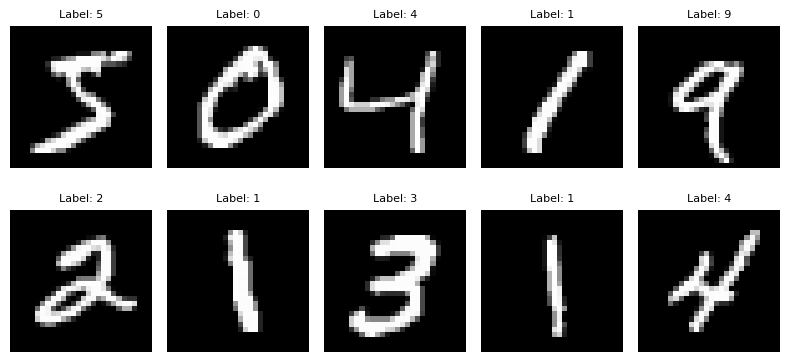

In [4]:
# Load dataset
train_data = MNIST(root=".", train=True, download=True)
# Visualise dataset
plt.figure(figsize=(8, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_data.data[i], cmap="gray")
    plt.title(f"Label: {train_data.targets[i].item()}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()

#### 2.2 Train the Logistic Regression model and CNN model

In [5]:
# 1) Load dataset 
train_data = MNIST(root=".", train=True, download=True)
test_data  = MNIST(root=".", train=False, download=True)

Xtr = train_data.data.numpy()
ytr = train_data.targets.numpy()
Xte = test_data.data.numpy()
yte = test_data.targets.numpy()

# 2) Logistic regression on flattened pixels
Xtr_lr = Xtr.reshape(len(Xtr), -1) / 255.0
Xte_lr = Xte.reshape(len(Xte), -1) / 255.0

logreg = LogisticRegression(max_iter=100, n_jobs=-1)
logreg.fit(Xtr_lr, ytr)
y_pred_lr = logreg.predict(Xte_lr)

# 3) CNN (PyTorch): uses image spatial structure
Xtr_t = torch.tensor(Xtr / 255.0, dtype=torch.float32).unsqueeze(1)
ytr_t = torch.tensor(ytr, dtype=torch.long)
Xte_t = torch.tensor(Xte / 255.0, dtype=torch.float32).unsqueeze(1)

loader = DataLoader(TensorDataset(Xtr_t, ytr_t), batch_size=128, shuffle=True)

cnn = nn.Sequential(
    nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 7 * 7, 128), nn.ReLU(),
    nn.Linear(128, 10)
)

opt = optim.Adam(cnn.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

cnn.train()
for epoch in range(5):
    pbar = tqdm(loader, desc=f"Epoch {epoch+1}/5", leave=False)
    for xb, yb in pbar:
        opt.zero_grad()
        loss = loss_fn(cnn(xb), yb)
        loss.backward()
        opt.step()
        pbar.set_postfix(loss=f"{loss.item():.3f}")

cnn.eval()
with torch.no_grad():
    y_pred_cnn = cnn(Xte_t).argmax(1).numpy()

# 4) Metrics
print("\nClassification results (test set)")
print(f"Logistic Regression accuracy: {accuracy_score(yte, y_pred_lr):.3f}")
print(f"CNN accuracy               : {accuracy_score(yte, y_pred_cnn):.3f}")

Epoch 1/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/469 [00:00<?, ?it/s]


Classification results (test set)
Logistic Regression accuracy: 0.926
CNN accuracy               : 0.990


The two models achieve markedly different accuracies.

Logistic regression treats each image as a flat vector of pixels and ignores spatial relationships between neighboring pixels. As a result, it can only capture global intensity patterns and simple linear decision boundaries, which limits its performance on image data.

In contrast, the convolutional neural network operates directly on the two-dimensional image structure. Convolutional layers learn local features such as edges, strokes, and corners, and deeper layers combine these into more complex patterns characteristic of handwritten digits. This ability to exploit spatial structure leads to a substantial improvement in classification accuracy.

The large accuracy gap illustrates a key principle in machine learning: **models that incorporate appropriate inductive biases for the data structure can achieve significantly better performance.**

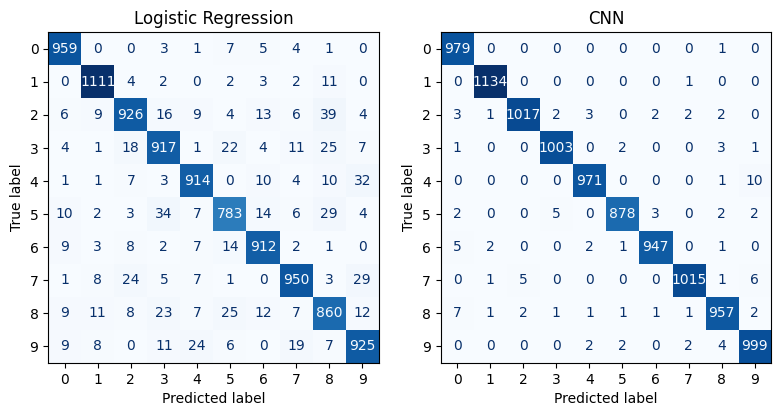

In [6]:
# 5) Visualise model accuracy: plot confusion matrix
class_names = [str(i) for i in range(10)]

fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)
ConfusionMatrixDisplay(
    confusion_matrix(yte, y_pred_lr),
    display_labels=class_names
).plot(ax=axes[0], cmap="Blues", colorbar=False, xticks_rotation=0)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(
    confusion_matrix(yte, y_pred_cnn),
    display_labels=class_names
).plot(ax=axes[1], cmap="Blues", colorbar=False, xticks_rotation=0)
axes[1].set_title("CNN")

plt.tight_layout()
plt.show()

**Interpreting the confusion matrices**

A confusion matrix summarises how a classification model performs on each class.

- **Rows** correspond to the true labels.
- **Columns** correspond to the predicted labels.
- Each entry shows how many samples of a given true class were predicted as a given class.

Correct predictions appear along the **diagonal** of the matrix. A strong diagonal indicates high classification accuracy. Off-diagonal entries represent misclassifications and show which classes are being confused with each other.

In the logistic regression model, misclassifications are more frequent and spread across multiple digit pairs. This indicates that the model struggles to separate classes when images are flattened and spatial information is lost.

In the CNN model, the matrix is much more concentrated along the diagonal. Most digits are classified correctly, and the remaining errors are limited to a small number of visually similar digits. This demonstrates that the CNN makes more structured and meaningful errors by exploiting spatial features in the images.

In [11]:
# 6) Per-class accuracy and main confusion (CNN and Logistic Regression)
def per_class_summary(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    acc = cm.diagonal() / cm.sum(axis=1)
    counts = cm.sum(axis=1)

    rows = []
    for d in range(len(acc)):
        row = cm[d].copy()
        row[d] = 0  # ignore correct predictions
        confused_as = row.argmax()
        rows.append({
            "Model": model_name,
            "Digit": d,
            "Total samples": counts[d],
            "Accuracy": acc[d],
            "Most often misclassified as": confused_as,
            "Misclassification count": cm[d, confused_as]
        })
    return pd.DataFrame(rows)

summary_lr  = per_class_summary(yte, y_pred_lr,  "Logistic Regression")
summary_cnn = per_class_summary(yte, y_pred_cnn, "CNN")
summary = pd.concat([summary_lr, summary_cnn], ignore_index=True)
summary

,Model,Digit,Total samples,Accuracy,Most often misclassified as,Misclassification count
0,Logistic Regression,0,980,0.978571,5,7
1,Logistic Regression,1,1135,0.978855,8,11
2,Logistic Regression,2,1032,0.897287,8,39
3,Logistic Regression,3,1010,0.907921,8,25
4,Logistic Regression,4,982,0.930754,9,32
5,Logistic Regression,5,892,0.877803,3,34
6,Logistic Regression,6,958,0.951983,5,14
7,Logistic Regression,7,1028,0.924125,9,29
8,Logistic Regression,8,974,0.882957,5,25
9,Logistic Regression,9,1009,0.916749,4,24


**Per-digit classification summary**

The table above summarises classification performance **for each digit**, separately for logistic regression and the CNN.

- **Total samples** shows how many test images are available for each digit.
- **Accuracy** is the fraction of correctly classified images for that digit.
- **Most often misclassified as** indicates which other digit this class is most frequently confused with.
- **Misclassification count** gives the number of times that confusion occurs.

This per-class view complements overall accuracy by revealing which digits are inherently harder to classify. Even for the CNN, errors are not uniformly distributed across classes but tend to occur between visually similar digits. The comparison also highlights how the CNN improves accuracy consistently across most digits, while logistic regression struggles more with certain classes due to its lack of spatial awareness.


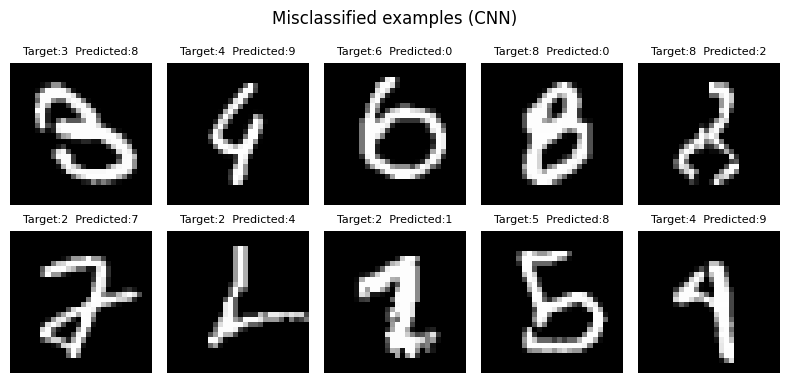

In [7]:
# 7) Visualise CNN predictions: correct vs incorrect
# Indices of correct and incorrect predictions
correct = np.where(y_pred_cnn == yte)[0]
incorrect = np.where(y_pred_cnn != yte)[0]

# Misclassified examples
plt.figure(figsize=(8, 4))
for i, idx in enumerate(incorrect[:10]):
    plt.subplot(2, 5, i+1)
    plt.imshow(Xte[idx], cmap="gray")
    plt.title(f"Target:{yte[idx]}  Predicted:{y_pred_cnn[idx]}", fontsize=8)
    plt.axis("off")
plt.suptitle("Misclassified examples (CNN)", fontsize=12)
plt.tight_layout()
plt.show()

### 3. Unsupervised learning (no labels)

In unsupervised learning, the goal is to analyze data **without access to target labels**.  
Instead of prediction, the focus is on understanding the structure of the data itself.

#### Task and dataset

We use the **California Housing tabular features** introduced earlier, but **ignore the target values**.  
Only the input features are used.

- **Inputs**  
  Each data point is described by a vector of numerical features (e.g. income, house age, population statistics).

- **No outputs**  
  There are no labels or targets provided to the algorithm.

This setting reflects many real-world situations where:
- labels are expensive or unavailable
- the goal is exploration rather than prediction

#### Methods used

We apply the standard unsupervised method:

- **K-Means clustering**  
  Groups data points into clusters based on similarity in feature space.




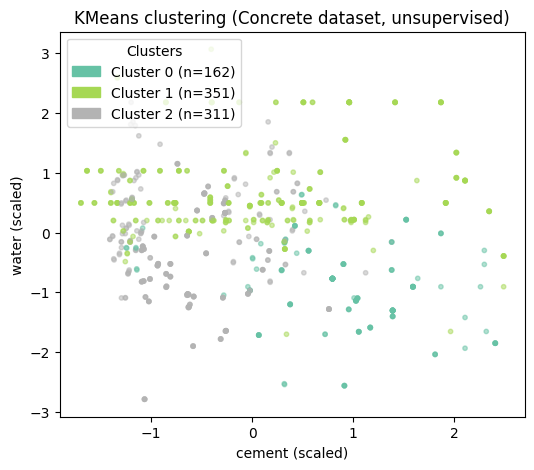

Cluster 0: 162 points
Cluster 1: 351 points
Cluster 2: 311 points


In [13]:
# 1) Choose two features to visualize (Concrete dataset)
f1, f2 = "cement", "water"   # feel free to change among 
# "cement", "slag", "ash", "water", "superplasticizer", "coarse_aggregate", "fine_aggregate", "age"
i1, i2 = list(concrete.drop(columns=["strength"]).columns).index(f1), list(concrete.drop(columns=["strength"]).columns).index(f2)

# 2) KMeans clustering in full feature space (use the scaled features from regression: Xtr_s)
kmeans = KMeans(n_clusters=3, random_state=0, n_init=10)
labels = kmeans.fit_predict(Xtr_s)

# Count points per cluster
unique_labels, counts = np.unique(labels, return_counts=True)

# 3) Plot clusters and print counts
plt.figure(figsize=(6, 5))
scatter = plt.scatter(Xtr_s[:, i1], Xtr_s[:, i2], c=labels, s=10, alpha=0.5, cmap="Set2")
plt.xlabel(f"{f1} (scaled)")
plt.ylabel(f"{f2} (scaled)")
plt.title("KMeans clustering (Concrete dataset, unsupervised)")

handles = [mpatches.Patch(color=scatter.cmap(scatter.norm(lbl)), label=f"Cluster {lbl} (n={cnt})")
           for lbl, cnt in zip(unique_labels, counts)]
plt.legend(handles=handles, title="Clusters")
plt.show()

for lbl, cnt in zip(unique_labels, counts):
    print(f"Cluster {lbl}: {cnt} points")

### Key takeaways

- Linear models provide strong baselines
- Neural networks capture nonlinear structure
- CNNs exploit spatial information in images
- ML can discover structure even without labels

The same workflow applies directly to scientific
and metamaterial design problems.
